In [ ]:
# default_exp callbacks

# Sampler Callbacks

> Callbacks can be passed to the sampler `run` method in order to hook into the various stages of the sampling process.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.datatypes.circuit import partition

import itertools as it
import functools
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import json

In [ ]:
#export
class Callback:
    
    def on_sampler_begin(self, *args, **kwargs):
        pass
    
    def on_sampler_end(self, *args, **kwargs):
        pass

    def on_circuit_begin(self, *args, **kwargs):
        pass
    
    def on_circuit_end(self, *args ,**kwargs):
        pass
    
    def on_protocol_begin(self, *args, **kwargs):
        pass
    
    def on_protocol_end(self, *args ,**kwargs):
        pass
    
    def store(self, log_dir, data, ext=""):
        with open(log_dir + f'/{self.__class__.__name__}_{str(ext)}.json', 'w') as f:
            json.dump(data, f)
    
class CallbackList:
    def __init__(self, sampler, callbacks=[]):
        self.sampler = sampler
        self.callbacks = callbacks
        self._add_default_callbacks()
        
    def _add_default_callbacks(self):
        pass
    
    def on_sampler_begin(self):
        for callback in self.callbacks:
            callback.on_sampler_begin(sampler=self.sampler)
            
    def on_sampler_end(self):
        for callback in self.callbacks:
            callback.on_sampler_end(sampler=self.sampler)
            
    def on_protocol_begin(self):
        for callback in self.callbacks:
            callback.on_protocol_begin(sampler=self.sampler)
            
    def on_protocol_end(self):
        for callback in self.callbacks:
            callback.on_protocol_end(sampler=self.sampler)
            
    def on_circuit_begin(self):
        for callback in self.callbacks:
            callback.on_circuit_begin(sampler=self.sampler)
            
    def on_circuit_end(self, local_vars):
        for callback in self.callbacks:
            callback.on_circuit_end(sampler=self.sampler, local_vars=local_vars)
            
    def __iter__(self):
        return iter(self.callbacks)

In [ ]:
#export
class PlotStats(Callback):
        
    def on_sampler_end(self, sampler):

        stats = sampler.stats()       
        fig,ax = plt.subplots(figsize=(6,4))
        
        xs = sampler.fault_gen.p_phy.T
        x_labels = np.array(sampler.fault_gen.partition_names)
        xs_vars = [np.var(x) for x in xs]
        # sorted_ids = np.argsort(xs_vars)[::-1]
        
        # xs = xs[sorted_ids]
        # x_labels = x_labels[sorted_ids]
    
        if len(stats) == 2:
            p_L_low, std = stats
            ax.errorbar(xs[0], p_L_low, fmt='--', c="black", yerr=std, label="Direct MC")
        else:
            p_L_low, low_std, p_L_up, up_std = stats
            
            ax.plot(xs[0], p_L_low, label="SS low")
            ax.fill_between(xs[0], p_L_low-low_std, p_L_low+low_std, alpha=0.2)
            ax.plot(xs[0], p_L_up, label="SS up")
            ax.fill_between(xs[0], p_L_up-up_std, p_L_up+up_std, alpha=0.2)

        ax.set_xlabel(x_labels[0])
        ax.set_ylabel("$p_L$")
        for i, (x, lbl) in enumerate(zip(xs[1:],x_labels[1:])):
            n_ax = ax.twiny()
            n_ax.plot(x, p_L_low)
            n_ax.cla() # clear graph (only use x-axis)
            
            n_ax.set_xscale('log')
                
            n_ax.xaxis.set_ticks_position('bottom')
            n_ax.xaxis.set_label_position('bottom')
            n_ax.spines['bottom'].set_position(('axes', -0.25 * (i+1)))
            n_ax.set_xlabel(lbl)
        
        ax.plot(xs[0], xs[0], 'k:', alpha=0.5)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()

In [ ]:
#export
class SubsetRates(Callback):
    def __init__(self, fail_only=True, log_dir=None):
        self.fail_only = fail_only
        self.log_dir = log_dir
        self.data = {}
        self.n_calls = 0
        
    def on_protocol_end(self, sampler):
        
        self.n_calls += 1
        for leaf in sampler.tree.root.leaves:
            if not leaf.is_root:
                if self.fail_only and not leaf.is_fail:
                    continue
                else:
                    path_str = ":".join([f'{n.name}' for n in leaf.path])
                    prod = 1
                    for n in leaf.path[1:]:
                        if n.ckey: prod *= sampler.Aws_pmax[n.ckey[0]][n.ckey[1]]
                        else: prod *= n.rate if n.name != None else 1 - n.rate
                        
                    prev_data = self.data.get(path_str, [])
                    fail_rate = leaf.rate if n.name != None else 1 - leaf.rate
                    self.data[path_str] = prev_data + [ (fail_rate, prod) ]
        
    def on_sampler_end(self, sampler):
                
        names = list(self.data.keys())
        rates = list(self.data.values())

        cols = [mpl.cm.jet(x) for x in np.linspace(0.0, 1.0, len(names))]
        xs = [range(self.n_calls - len(r), self.n_calls) for r in rates]
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        y_labels = ['$p_{fail}$', '$\prod_P A_w p_P$']
            
        for i in range(len(names)):
            fail_rates, path_rates = np.array(rates[i]).T
            ax[0].plot(xs[i], fail_rates, c=cols[i])
            ax[0].set_xlim([0, self.n_calls])
            ax[0].set_xlabel('# of samples')
            ax[0].set_ylabel('$p_{fail}$')
            ax[1].plot(xs[i], path_rates, c=cols[i])
            ax[1].set_xlim([0, self.n_calls])
            ax[1].set_xlabel('# of samples')
            ax[1].set_ylabel('$\prod_P A_w p_P$')
            
        ax[1].legend(names, bbox_to_anchor=(1.04, 1), loc='upper left')
        
        if self.log_dir: self.store(self.log_dir, self.data, ext=self.n_calls)

        return None

In [ ]:
#export
class PathProducts(Callback):
    def __init__(self, log_dir=None):
        self.log_dir = log_dir
        self.data = {'name':[], 'Aw':[], 'pAw':[], 'pAw-1':[], 'leaf_cnts':[], 'is_fail':[]}
        
    def on_sampler_end(self, sampler):
        for leaf in sampler.tree.root.leaves:
            if not leaf.is_root:
                prod = 1
                for n in leaf.path[1:]:
                    if n.ckey: prod *= sampler.Aws_pmax[n.ckey[0]][n.ckey[1]]
                self.data['Aw'].append(prod)

                for n in leaf.path[1:-1]:
                    if not n.ckey: prod *= n.rate
                self.data['pAw-1'].append(prod)

                prod *= leaf.rate if leaf.is_fail else 0
                self.data['pAw'].append(prod)

                path_str = ":".join([f'{n.name}' for n in leaf.path])
                self.data['name'].append(path_str)
                self.data['leaf_cnts'].append(leaf.counts)
                self.data['is_fail'].append(leaf.is_fail)
        self.plot()
        if self.log_dir: 
            self.store(self.log_dir, self.data)


    def plot(self):
        names, Aw, pAw, pAw_1, cnts, is_f = self.data.values()
        sorted_ids = np.argsort(Aw)[::-1]
        names = np.array(names)[sorted_ids]
        is_f = np.array(is_f)[sorted_ids]
        Aw = np.array(Aw)[sorted_ids]
        pAw = np.array(pAw)[sorted_ids]
        pAw_1 = np.array(pAw_1)[sorted_ids]
        cnts = np.array(cnts)[sorted_ids]
        f_cnts = cnts.copy()
        f_cnts[~is_f] = 0
            
        fig,ax = plt.subplots(2,1, figsize=(15,5), sharex=True)
        ax[0].bar(names, Aw, label='$\prod_{n\in P} A_w$')
        ax[0].bar(names, pAw_1, label='$\prod_{n-1\in P} A_{w} p_n$')
        ax[0].bar(names, pAw, label='$\prod_{n\in P} A_{w} p_n$')
        ax[0].set_yscale('log')

        ax[1].bar(names, cnts, label="Path count")
        ax[1].bar(names, f_cnts, label="Fail count")
        ax[1].set_yscale('log')

        xticklabels = ax[1].get_xticklabels()
        plt.setp(xticklabels, ha="right", rotation=45)
        for i, (path, is_fail) in enumerate(zip(names,is_f)):
            if is_fail: plt.setp(xticklabels[i], weight='bold')

        ax[0].legend(loc='upper right')
        ax[1].legend(loc='upper right')
        
        return None

In [ ]:
#export
class RelStdTarget(Callback):
    def __init__(self, target=0.1, include_delta=True):
        self.target = target
        self.include_delta = include_delta
        
    def on_protocol_end(self, sampler):
        if hasattr(sampler, 'p_idx'):
            p_L, err = sampler.stats(p_idx=sampler.p_idx)
        else:
            
            p_L = sampler.tree.rate
            std = np.sqrt(sampler.tree.variance)
            delta = sampler.tree.delta
            
            err = std + delta if self.include_delta else std
        
        if p_L > 0 and err / p_L < self.target: 
            print(f'Rel. std target of {self.target} reached. Sampling stopped.') 
            sampler.stop_sampling = True

In [ ]:
#export
class ErvPerSample(Callback):
    def __init__(self, log_dir=None):
        self.log_dir = log_dir
        self.data = []
        self.n_calls = 0
        
    def on_protocol_begin(self, **kwargs):
        self.current_erv = []
        
    def on_circuit_end(self, local_vars, **kwargs):
        erv = local_vars["loop_out"]["erv"]
        self.current_erv.append(erv)
        
    def on_protocol_end(self, **kwargs):
        self.data.append(self.current_erv)
        self.n_calls += 1
        
    def on_sampler_end(self, **kwargs):
        
        # import warnings
        # warnings.filterwarnings('error')
        # print(self.data)
        
        lens = np.array([len(d) for d in self.data])
        mask = np.arange(lens.max()) < lens[:, None]
        out = np.zeros(mask.shape)
        
        out[~mask] = np.nan
        out[mask] = np.concatenate(self.data)
        
        fig, ax = plt.subplots()
        
        for row in out.T:
            ax.scatter(range(self.n_calls), row)#, c='tab:blue')
        ax.set_yscale('log')
        ax.set_xlabel('# of samples')
        ax.set_ylabel('ERV of selected subset')
            
        if self.log_dir: 
            self.store(self.log_dir, self.data, ext=self.n_calls)

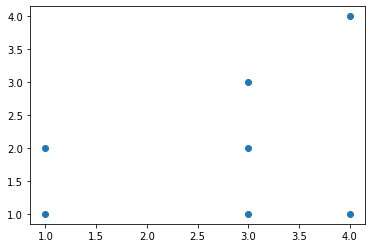

In [ ]:
data = [[1,2], [], [1,2,3], [1,4]]
n_samples = [1,2,3,4]

# np.array(data).shape
lens = np.array([len(a) for a in data])
mask = np.arange(lens.max()) < lens[:,None]
out = np.zeros(mask.shape)

out[~mask] = None
out[mask] = np.ma.concatenate(data)

out

for row in out.T:
    plt.scatter(n_samples, row, c='tab:blue')
    

# plt.scatter(range(3),[])

In [ ]:
#export
class StatsPerSample(Callback):
    def __init__(self, log_dir=None):
        self.log_dir = log_dir
        self.data = []
        self.n_calls = 0
        
    def on_protocol_end(self, sampler):
        if hasattr(sampler, 'p_idx'):
            stats = sampler.stats(p_idx=sampler.p_idx)
        else:
            p_L = sampler.tree.rate
            std = np.sqrt(sampler.tree.variance)
            delta = sampler.tree.delta
            std_delta = np.sqrt(sampler.tree.norm_variance)
            stats = [p_L, std, delta, std_delta]
            
        self.data.append(stats)
        self.n_calls += 1
    
    def on_sampler_end(self, **kwargs):
        # p_L, std, delta, delta_std = np.array(self.data).T
        data = np.array(self.data).T
        x = range(self.n_calls)
        
        # exclude_delta = True if np.all(delta == 0) else False
        # n_cols = 2 if exclude_delta else 3
        n_cols = data.shape[0]
            
        fig, ax = plt.subplots(1, n_cols, figsize=(8*n_cols, 5))
        labels = ['$p_L$', 'std[$p_L$]', '$\delta$', 'std[$\delta$]']
        
        for i in range(n_cols):
            ax[i].plot(x, data[i])
            ax[i].set_xlabel('# of samples')
            ax[i].set_ylabel(labels[i])
            if i != 0:
                ax[i].set_yscale('log')
#         ax[0].plot(x, p_L)
#         ax[0].fill_between(x, p_L - std, p_L + std, alpha=0.2)
#         ax[1].plot(x, std)
        
#         if not exclude_delta:
#             ax[2].plot(x, delta)
#             ax[2].fill_between(x, delta - delta_std, delta + delta_std, alpha=0.2)
#             ax[2].set_yscale('log')
#             labels = ['$p_L\pm std$', 'std', '$\delta$']
#         else:
#             labels = ['$p_L\pm std$', 'std']
            
#         for i, label in enumerate(labels):
#             ax[i].set_xlabel('# of samples')
#             ax[i].set_ylabel(label)
            
        if self.log_dir: 
            self.store(self.log_dir, self.data, ext=self.n_calls)

In [ ]:
# export
class VerboseCircuitExec:
    
    def on_circuit_end(self, sampler, local_vars):
        circuit = local_vars.get('circuit', None)
        circuit_hash = local_vars.get('circuit_hash', None)
        fault_circuit = local_vars.get('fault_circuit', None)
        faults = local_vars.get('faults', None)
        node = local_vars.get('node', None)
        _node = local_vars.get('_node', None)
        msmt = local_vars.get('msmt', None)
        
        fs = [] if not circuit._noisy else [f'Tick {tick}: {fault_circuit[tick]}' for tick,_ in faults]
        if circuit_hash not in self.protocol._circuits.keys():
            print(f'Node {_node}, Circuit {circuit} -> {node}') # COR nodes
        else: # circuit nodes
            print(f'Node {_node}, faults {fs}, measured {msmt} -> {node}')